In [1]:
import numpy as np
from scipy import stats
from scipy.linalg import eig
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from bayesiankalman import mcmc
from tqdm import tqdm, trange
import seaborn as sns
import statsmodels.api as sm
import cdpm
from cdpm import CondDirichletProcessMix
from pandas_datareader import data as web
from sklearn.preprocessing import normalize

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
alpha_for_ci = .95
num_draws = int(1e4)

In [4]:
# data_tmp = web.DataReader('HOUST', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
# data_tmp = web.DataReader('QUSR628BIS', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
gdp = web.DataReader('GDP', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
# QUSR628BIS: real residential property price (US)
# data_tmp = pd.read_excel('/home/sangrey/Downloads/HPI_PO_monthly_hist.xls', header=2, index_col='Month').dropna(
#     how='all').iloc[:,0].to_frame().apply(np.log).diff()
# data_tmp = web.DataReader('PAYEMS', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
consumer_loans = web.DataReader('TOTALFC', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()

houst = web.DataReader('HOUST', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
cpi = web.DataReader('CPIAUCSL', data_source='fred', start='1900-01-01').apply(np.log).diff().dropna()
recessions_tmp = web.DataReader('USREC', data_source='fred', start='1900-01-01')
data = pd.concat([cpi, houst, consumer_loans], join='inner', axis=1).transform(lambda x: (x - x.mean()) / x.std())
data = pd.merge(left=data, right=recessions_tmp, left_index=True,
                right_index=True).ffill().dropna()
data.columns = ['CPI', 'Housing Starts', 'Consumer Loans', 'Recessions']


In [5]:
rel_cols = ['CPI', 'Housing Starts', 'Consumer Loans']

In [6]:
data.count()

CPI               700
Housing Starts    700
Consumer Loans    700
Recessions        700
dtype: int64

In [7]:
data.head()

CPI  Housing Starts  Consumer Loans  Recessions
DATE                                                            
1959-02-01 -1.073650        0.080353       -0.328726           0
1959-03-01 -1.292515       -0.342764       -0.089645           0
1959-04-01 -0.854898       -0.221666        0.299401           0
1959-05-01 -0.308528       -0.721723        0.416121           0
1959-06-01 -0.200938        0.047538        0.936445           0

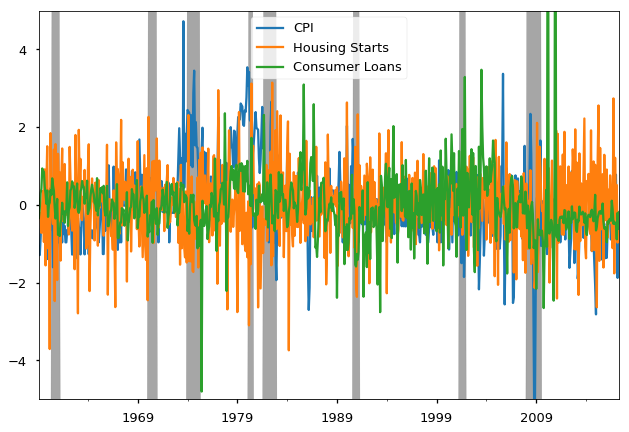

In [8]:
data_fig, data_ax = plt.subplots(1,1)
data[rel_cols].plot(ax=data_ax)
minval, maxval = [-5, 5]
data_ax.fill_between(data.index, (maxval - minval) * data['Recessions'] + minval, minval, color='grey', alpha=.7)
data_ax.set_ylim([minval, maxval])
data_ax.set_xlabel("")
data_fig.savefig('../doc/figures/consumer_finances.tmp.pdf', bbox_inches='tight', pad_inches=0)

In [9]:
data.describe()

CPI  Housing Starts  Consumer Loans  Recessions
count  7.000000e+02    7.000000e+02    7.000000e+02  700.000000
mean  -1.141944e-17   -9.198991e-18    1.177629e-17    0.132857
std    1.000000e+00    1.000000e+00    1.000000e+00    0.339663
min   -6.628686e+00   -3.742505e+00   -4.803465e+00    0.000000
25%   -5.522256e-01   -5.899573e-01   -4.224131e-01    0.000000
50%   -1.393983e-01    1.469399e-02   -8.357829e-02    0.000000
75%    4.610694e-01    6.036711e-01    3.784791e-01    0.000000
max    4.723364e+00    3.144703e+00    1.291451e+01    1.000000

## Estimation

In [10]:
time_dim = data.shape[0]
regressor_dim = len(rel_cols)
regressand_dim = len(rel_cols)

In [11]:
stick_scale = 2
# mean and standard deviation
beta_mu, beta_sigma = 0 * np.ones(regressand_dim), 0.05 * np.eye(regressand_dim, regressand_dim) 
comp_cov_df, comp_cov_scale = regressand_dim + 2, .5 * np.eye(regressand_dim,regressand_dim)

In [12]:
prior = {
    'comp': {
        'coeff': {'mean':list(beta_mu.ravel()), 'cov': list(beta_sigma.ravel())},
        'cov': {'scale': list(comp_cov_scale.ravel()), 'df': [comp_cov_df]}
    },
    'sticks': {
        'params': {
            'c': [stick_scale]
        }
    }
}

## Initialization

In [13]:
model = CondDirichletProcessMix(beta_mu, comp_cov=comp_cov_scale / comp_cov_df, regressor=data[rel_cols].iloc[:-1], 
                                regressand=data[rel_cols].iloc[1:])

In [14]:
cluster_identity_draws = np.empty((num_draws, time_dim-1))
stick_draws = np.full((num_draws, 50),np.nan)
beta_draws = np.full((num_draws, 50, regressor_dim, regressand_dim),np.nan)
comp_cov_draws = np.full((num_draws, 50, regressand_dim, regressand_dim),np.nan)
trans_mat_draws = np.full((num_draws, 50, 50),np.nan)

In [15]:
 for draw_idx in trange(num_draws):
    cluster, sticks, beta, cov, trans_mat = model(prior)
    cluster_identity_draws[draw_idx] = cluster
    stick_draws[draw_idx,:len(sticks)] = sticks
    beta_draws[draw_idx,:len(beta), :, :] = beta
    comp_cov_draws[draw_idx, :len(cov), :, :] = cov
    trans_mat_draws[draw_idx,:len(trans_mat), :len(trans_mat)] = trans_mat

100%|██████████| 50000/50000 [08:41<00:00, 95.93it/s] 


In [16]:
for _ in trange(1000):
    cluster, sticks, beta, cov, trans_mat = model(prior)
    assert(int(cluster.max() +1) == sticks.size == beta.shape[0] == cov.shape[0] == trans_mat.shape[0] == trans_mat.shape[1])

100%|██████████| 1000/1000 [00:10<00:00, 94.45it/s]


## Simulation results

In [17]:
percentiles = [1,5, 25, 50, 75, 95, 99]

In [18]:
state_quantiles = np.percentile(cluster_identity_draws, percentiles, axis=0)

## Get the dynamics of Housing Starts

In [19]:
trans_mat = pd.DataFrame(np.nanmean(trans_mat_draws[:, :10, :10], axis=0))
trans_mat

0         1         2         3         4         5         6  \
0  0.375390  0.241313  0.179080  0.109062  0.045460  0.020050  0.011205   
1  0.338717  0.262816  0.190758  0.109862  0.046174  0.020794  0.011663   
2  0.340230  0.241559  0.204043  0.116899  0.045930  0.020731  0.011583   
3  0.343256  0.242015  0.185603  0.127433  0.050547  0.020733  0.011373   
4  0.341327  0.241681  0.187454  0.114296  0.060403  0.024484  0.011449   
5  0.338449  0.239114  0.188875  0.116677  0.048117  0.034613  0.015913   
6  0.332709  0.237833  0.188018  0.118592  0.050069  0.021859  0.027513   
7  0.329231  0.237224  0.186618  0.120788  0.050587  0.022377  0.012209   
8  0.327965  0.232936  0.185882  0.117682  0.054022  0.023230  0.013520   
9  0.328698  0.226898  0.182632  0.120751  0.055898  0.024815  0.012931   

          7         8         9  
0  0.007576  0.005729  0.004421  
1  0.007997  0.005832  0.004670  
2  0.007851  0.005767  0.004611  
3  0.007925  0.005700  0.004643  
4  0.007632  0.005971  0.004348  
5  0.007365  0.005458  0.004353  
6  0.012224  0.005563  0.004684  
7  0.025298  0.009698  0.004465  
8  0.008867  0.024719  0.008923  
9  0.009131  0.006486  0.024413

In [20]:
np.squeeze(np.nanmean(beta_draws[:,:10,:,:], axis=0))

array([[[  4.07753846e-01,  -2.33159743e-02,   2.75258397e-02],
        [ -5.60501928e-02,  -2.13211433e-01,   1.05460095e-02],
        [  1.73139756e-02,  -5.21138398e-03,   1.70221922e-01]],

       [[  3.19100953e-01,   8.67591812e-03,  -1.39973832e-02],
        [ -3.69393854e-02,  -2.02269905e-01,   2.83815997e-02],
        [  5.58577067e-03,  -5.37113725e-03,   1.99302564e-01]],

       [[  2.84324731e-01,   2.24651318e-02,  -1.59994268e-02],
        [ -3.72068342e-02,  -1.90017982e-01,   2.66177804e-02],
        [  7.04726985e-05,   8.44679874e-04,   2.00004638e-01]],

       [[  2.26298587e-01,   1.90611225e-02,  -3.81643684e-03],
        [ -2.93351248e-02,  -1.41831400e-01,   2.29493509e-02],
        [  3.42413635e-03,   6.15021270e-03,   1.51087210e-01]],

       [[  1.41675898e-01,   2.33955922e-02,  -6.71902490e-05],
        [ -1.35491572e-02,  -7.63062981e-02,   1.52484166e-02],
        [  7.25689691e-03,   2.72288001e-03,   9.84466819e-02]],

       [[  9.43391103e-02,   2

In [21]:
np.squeeze(np.nanmean(comp_cov_draws[:,:10,:,:], axis=0))

array([[[  5.11351090e-01,   2.13224611e-01,   1.58848955e-01],
        [  1.95036521e-01,   5.26520153e-01,   1.32015531e-01],
        [  2.31469725e-01,   1.93229694e-01,   2.79627657e-01]],

       [[  3.52439933e-01,   1.23678214e-02,   7.86753197e-03],
        [  7.56564299e-02,   6.57539008e-01,  -1.00861404e-02],
        [  4.96037366e-02,   2.30283739e-04,   5.52767723e-01]],

       [[  4.73834621e-01,  -1.49062515e-02,  -1.79768504e-02],
        [ -1.39113776e-02,   6.89242409e-01,   5.05075941e-03],
        [ -1.69907901e-02,   5.23801254e-03,   8.01333244e-01]],

       [[  7.65370937e-01,   4.78231405e-02,   8.48543093e-03],
        [  4.78228521e-02,   6.32024819e-01,   2.55811956e-02],
        [  8.49812958e-03,   2.56543504e-02,   1.09208784e+00]],

       [[  1.32119202e+00,   1.46401007e-01,   3.99693929e-02],
        [  1.46401007e-01,   4.96299646e-01,   7.47812269e-02],
        [  3.99693929e-02,   7.47812269e-02,   2.51819256e+00]],

       [[  1.76066386e+00,   2

In [22]:
def get_eigvecs_with_eigval_close_to_1(mat):
    
    mat = pd.DataFrame(mat).dropna(axis=0, how='all').dropna(axis=1).T
    
    eigvals, eigvecs = eig(mat)
    
    idx = np.argsort(eigvals)[::-1][0]
    
    return pd.DataFrame(np.clip(np.real(eigvecs[:, idx]), a_min=0, a_max=1)).T

In [23]:
def compute_stationary_distribution(trans_mat_draws):
    
    stat_dist = map(get_eigvecs_with_eigval_close_to_1, tqdm(trans_mat_draws))
    
    return_df = pd.concat(stat_dist, join='outer')
    return_df.index = range(len(trans_mat_draws))

    return return_df

In [24]:
stationary_dist = compute_stationary_distribution(trans_mat_draws)

100%|██████████| 50000/50000 [01:33<00:00, 535.58it/s]


In [25]:
stationary_dist.mean().iloc[:10]

0    0.313619
1    0.220713
2    0.171768
3    0.105341
4    0.044612
5    0.019203
6    0.010703
7    0.007256
8    0.005368
9    0.004257
dtype: float64

In [26]:
data_est_mat = np.empty((time_dim-1,len(rel_cols), num_draws // 200))

In [27]:
for draw in trange(data_est_mat.shape[-1]):
    for t_idx in range(1, time_dim):
        cluster_identity = cluster_identity_draws[draw,t_idx-1].astype(int)
        props = pd.DataFrame(trans_mat_draws[draw,cluster_identity]).dropna().transform(lambda x: x / x.sum())
        cl_idx = np.asscalar(np.flatnonzero(np.random.multinomial(n=1, pvals=props.values.ravel())))
        data_est_mat[t_idx-1, :, draw] = stats.multivariate_normal.rvs(
            mean=data[rel_cols].iloc[t_idx-1] @ beta_draws[draw, cluster_identity],
            cov=comp_cov_draws[draw, cl_idx])


  4%|▍         | 10/250 [00:17<06:53,  1.72s/it]/home/sangrey/anaconda3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 250/250 [07:17<00:00,  1.74s/it]


In [28]:
np.median(cluster_identity_draws.ravel())

1.0

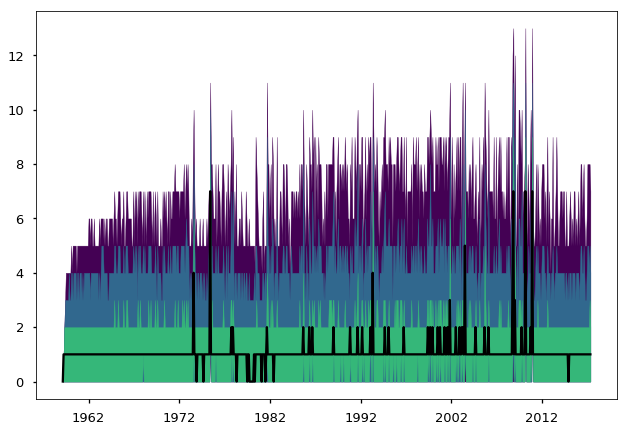

In [29]:
cluster_id_fig, cluster_id_ax = plt.subplots(1,1)
mcmc.fan_plot(cluster_id_ax, pd.DataFrame(cluster_identity_draws.T, index=data.index[1:]),  percentiles, 
              color='black')
cluster_id_fig.savefig('../doc/figures/multivariate_consumper_finance_clusters.pdf', bbox_inches='tight', 
                       pad_inches=0)

In [30]:
data_est_mat.shape

(699, 3, 250)

In [31]:
data.head()

CPI  Housing Starts  Consumer Loans  Recessions
DATE                                                            
1959-02-01 -1.073650        0.080353       -0.328726           0
1959-03-01 -1.292515       -0.342764       -0.089645           0
1959-04-01 -0.854898       -0.221666        0.299401           0
1959-05-01 -0.308528       -0.721723        0.416121           0
1959-06-01 -0.200938        0.047538        0.936445           0

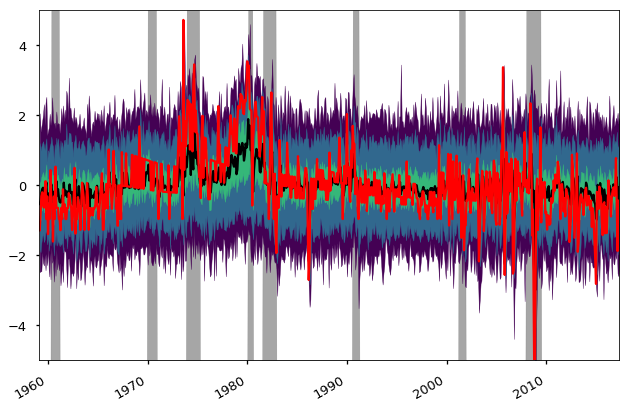

In [32]:
data_comparison_fig, data_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(data_comparison_ax, pd.DataFrame(np.squeeze(data_est_mat[:,0,:]), index=data.index[1:]), 
              percentiles, color='black')
data['CPI'].plot(ax=data_comparison_ax, c='red')
minval, maxval = data_comparison_ax.get_ylim()
data_comparison_ax.fill_between(data['Recessions'] * (maxval - minval) + minval, minval, color='grey', alpha=.7)
data_comparison_ax.set_ylim([minval, maxval])
data_comparison_ax.set_xlabel("")
minval, maxval = data_ax.get_ylim()
data_comparison_ax.fill_between(data.index, (maxval - minval) * data['Recessions'] + minval, minval, 
                                color='grey', alpha=.7, zorder=0)
data_comparison_ax.set_ylim([minval, maxval])
data_comparison_filename = '../doc/figures/housing_mixture.pdf'
data_comparison_fig.savefig(data_comparison_filename, bbox_inches='tight', pad_inches=0)

In [33]:
pit1 = mcmc.probability_integral_transform(pd.DataFrame(np.squeeze(data_est_mat[:,0,:]), index=data.index[1:]).dropna(axis=1), 
                                           data['CPI'].iloc[1:])

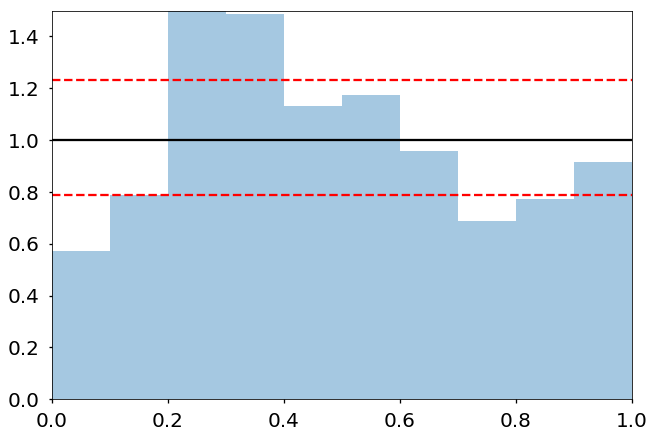

In [34]:
pit_fig = plt.figure()
pit_ax = pit_fig.add_subplot(111)
nbins = 10
sns.distplot(pit1, kde=False, norm_hist=True, ax=pit_ax, bins=nbins)
pit_ax.set_xlim([0,1])
pit_ax.set_ylim([0,1.5])
for label in pit_ax.get_xticklabels():
    label.set_fontsize(20)
for label in pit_ax.get_yticklabels():
    label.set_fontsize(20)
pit_ci_bottom, pit_ci_top = stats.binom.interval(alpha=alpha_for_ci, n=pit1.size, p=nbins**(-1)) 
pit_ax.axhline(pit_ci_bottom * (nbins / pit1.size), color='red', linestyle='dashed')
pit_ax.axhline(pit_ci_top * (nbins / pit1.size), color='red', linestyle='dashed')
pit_ax.axhline(1, color='black')
pit_fig.savefig('../doc/figures/consumer_loans_pit.pdf', bbox_inches='tight', pad_inches=0)

In [35]:
stats.kstest(np.sort(pit1.values.ravel()), cdf='uniform', mode='asymp')

KstestResult(statistic=0.074025751072961388, pvalue=0.00094188276296610111)

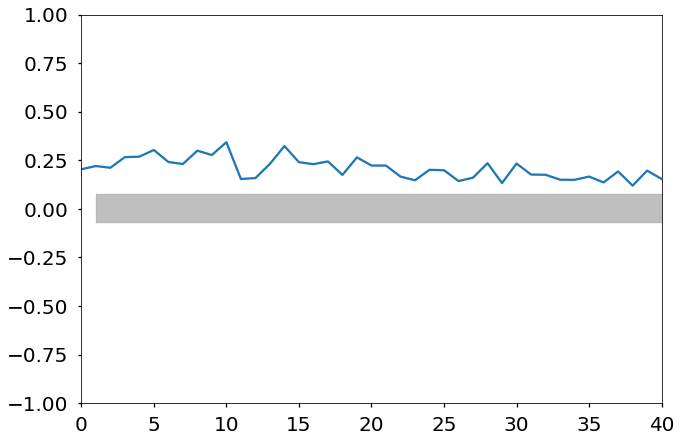

In [36]:
acf_fig, acf_ax = plt.subplots()
n_lags = 50
acf_ax.plot(sm.tsa.acf(pit1, unbiased=True, nlags=n_lags)[1:])
acf_ax.fill_between(np.arange(1, n_lags), -1.96 / np.sqrt(pit1.size), 1.96 / np.sqrt(pit1.size), color='grey', 
                   alpha=.5)
acf_ax.set_ylim([-1,1])
for label in acf_ax.get_xticklabels():
    label.set_fontsize(20)
for label in acf_ax.get_yticklabels():
    label.set_fontsize(20)
acf_ax.set_xlim([0, 40])
acf_fig.savefig('../doc/figures/cpi_pit_autocorr.tmp.pdf', bbox_inches='tight', pad_inches=0)